# Introduction to Pyro

## Concept of Probabilistic programming languages (PPLs)

"Specifying probabilistic models directly can be cumbersome and implementing them can be very error-prone. Probabilistic programming languages (PPLs) solve these problems by marrying probability with the representational power of programming languages."

## What is Inference?

"By observing the outcome of a probabilistic program, we can describe an inference problem, roughly translated as: “what must be true if this random choice had a certain observed value?"

# What is Pyro?

Pyro programs are just Python programs, while its main inference technology is stochastic variational inference

## What is Stochastic Variational Inference?

Stochastic Variational Inference (SVI) is a scalable variant of Variational Inference (VI). Standard VI can be computationally demanding, especially when dealing with large datasets, since it requires computing expectations over the entire dataset at each iteration. This is where SVI comes into play.

The key idea behind SVI is to estimate these expectations by subsampling the data at each iteration and computing expectations over the subsample, which can significantly reduce computational costs. This is similar to how Stochastic Gradient Descent (SGD) provides a scalable alternative to full-data Gradient Descent by computing gradients on small mini-batches of data.

## Hands on Pyro

In [1]:
%reset -s -f

In [2]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro


In [3]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.5')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Background: probabilistic machine learning

Most data analysis problems can be understood as elaborations on three basic high-level questions:

1. What do we know about the problem before observing any data?

2. What conclusions can we draw from data given our prior knowledge?

3. Do these conclusions make sense?

In the probabilistic or Bayesian approach to data science and machine learning, we formalize these in terms of mathematical operations on probability distributions.

## Background: probabilistic models


First, we express everything we know about the variables in a problem and the relationships between them in the form of a probabilistic model, or a joint probability distribution over a collection of random variables. A model has observations $\mathbf{x}$ and latent random variables $\mathbf{z}$ as well as parameters $\theta$. It usually has a joint density function of the form
$$
p_\theta(\mathbf{x}, \mathbf{z})=p_\theta(\mathbf{x} \mid \mathbf{z}) p_\theta(\mathbf{z})
$$
The distribution over latent variables $p_\theta(\mathbf{z})$ in this formula is called the `prior`, and the distribution over observed variables given latent variables $p_\theta(\mathbf{x} \mid \mathbf{z})$ is called the `likelihood`.

We typically require that the various conditional probability distributions $p_i$ that make up a model $p_\theta(\mathbf{x}, \mathbf{z})$ have the following properties (generally satisfied by the distributions available in Pyro and PyTorch Distributions):

- we can efficiently sample from each $p_i$
- we can efficiently compute the pointwise probability density $p_i$
- $p_i$ is differentiable w.r.t. the parameters $\theta$

## Plate notation

Directed acyclic graphs depict joint distributions:
Circular nodes indicate random variables, edges indicate dependence:
$$
p\left(y_n \mid x_n, \alpha, \beta, \sigma\right)
$$
Unshaded nodes are latent variables; shaded nodes are observed variables. "Plates" (rectangles) indicate independent copies:
$$
p\left(y_1, \ldots, y_N \mid x_1, \ldots, x_N, \alpha, \beta, \sigma\right)=\prod_n p\left(y_n \mid x_n, \alpha, \beta, \sigma\right)
$$

## Background: inference, learning and evaluation

Once we have specified a model, Bayes' rule tells us how to use it to perform inference, or draw conclusions about latent variables from data, by computing the posterior distribution over $\mathbf{z}$ :
$$
p_\theta(\mathbf{z} \mid \mathbf{x})=\frac{p_\theta(\mathbf{x}, \mathbf{z})}{\int d \mathbf{z} p_\theta(\mathbf{x}, \mathbf{z})}
$$
To check the results of modeling and inference, we would like to know how well a model fits observed data $x$, which we can quantify with the evidence or marginal likelihood
$$
p_\theta(\mathbf{x})=\int d \mathbf{z} p_\theta(\mathbf{x}, \mathbf{z})
$$
and also to make predictions for new data, which we can do with the posterior predictive distribution
$$
p_\theta\left(x^{\prime} \mid \mathbf{x}\right)=\int d \mathbf{z} p_\theta\left(x^{\prime} \mid \mathbf{z}\right) p_\theta(\mathbf{z} \mid \mathbf{x})
$$
Finally, it is often desirable to learn the parameters $\theta$ of our models from observed data $x$, which we can do by maximizing the marginal likelihood:
$$
\theta_{\max }=\operatorname{argmax}_\theta \mathrm{p}_\theta(\mathbf{x})=\operatorname{argmax}_\theta \int \mathrm{d} \mathbf{z} \mathrm{p}_\theta(\mathbf{x}, \mathbf{z})
$$


## Example: Geography and national income

In [4]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [6]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

/var/folders/d7/661_pryx1zx9ctp4z8417_d80000gn/T/ipykernel_35378/3494630367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rgdppc_2000"] = np.log(df["rgdppc_2000"])


In [7]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


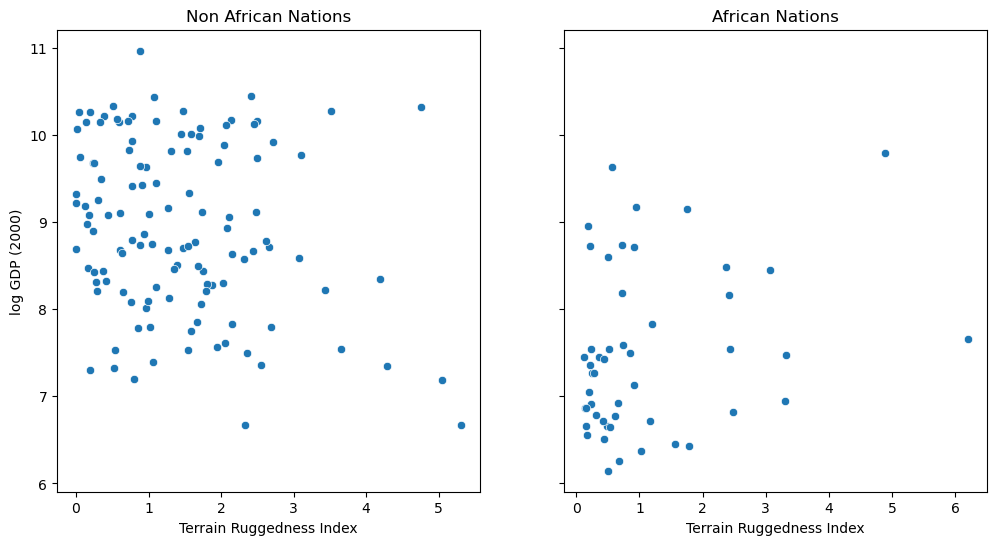

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [12]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)): # correspondent to N sampling of the plate-notation
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

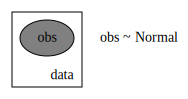

In [13]:
#  visualize the resulting model using pyro.render_model():
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

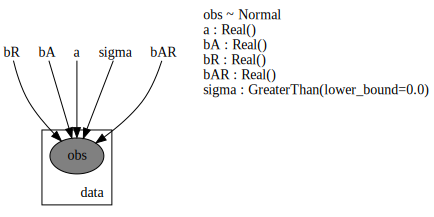

In [15]:
# visualoize w/ params
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

## From MLE to Bayesian inference

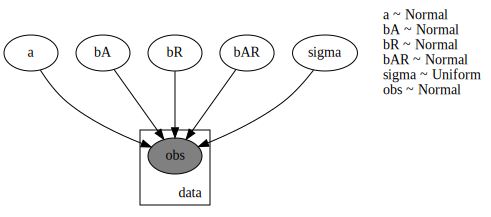

In [18]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

In [19]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}


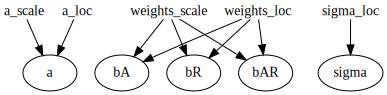

In [20]:
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

In [21]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

Background: Estimating and optimizing the Evidence Lower Bound (ELBO)
The functional of model $p_\theta(\mathbf{x}, \mathbf{z})$ and guide $q_\phi(\mathbf{z})$ that we will optimize is the ELBO, defined as an expectation w.r.t. to samples from the guide:
$$
\mathrm{ELBO} \equiv \mathbb{E}_{q_\phi(\mathbf{z})}\left[\log p_\theta(\mathbf{x}, \mathbf{z})-\log q_\phi(\mathbf{z})\right]
$$
By assumption we can compute all of the probabilities inside the expectation, and since the guide $q$ is assumed to be a parametric distribution we can sample from, we can compute Monte Carlo estimates of this quantity as well as of gradients with respect to model and guide parameters, $\nabla_{\theta, \phi} E L B O$
Optimizing the ELBO over model and guide parameters $\theta, \phi$ via stochastic gradient descent using these gradient estimates is sometimes called stochastic variational inference (SVI); for an extended introduction to SVI, see SVI Part I.

In [22]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Elbo loss: 694.9404826164246
Elbo loss: 524.3822077512741
Elbo loss: 475.668145775795
Elbo loss: 399.9908837676048
Elbo loss: 315.23277485370636
Elbo loss: 254.76769989728928
Elbo loss: 248.237040579319
Elbo loss: 248.4266900420189
Elbo loss: 248.46450024843216
Elbo loss: 257.4146338701248


CPU times: user 2.28 s, sys: 81.8 ms, total: 2.36 s
Wall time: 2.6 s


Text(0, 0.5, 'ELBO loss')

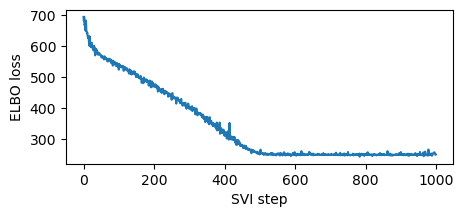

In [23]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [24]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.173145
AutoNormal.scales.a 0.07036688
AutoNormal.locs.bA -1.847466
AutoNormal.scales.bA 0.14070092
AutoNormal.locs.bR -0.19032115
AutoNormal.scales.bR 0.044044234
AutoNormal.locs.bAR 0.35599765
AutoNormal.scales.bAR 0.079374395
AutoNormal.locs.sigma -2.2058632
AutoNormal.scales.sigma 0.06052672


In [25]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

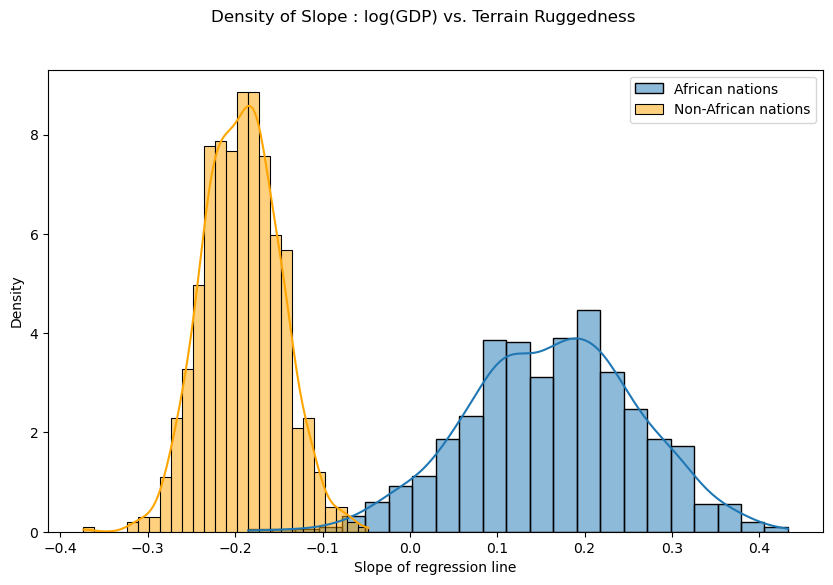

In [26]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

# Model Evaluation in Pyro

## Background: Bayesian model evaluation with posterior predictive checks

In [27]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

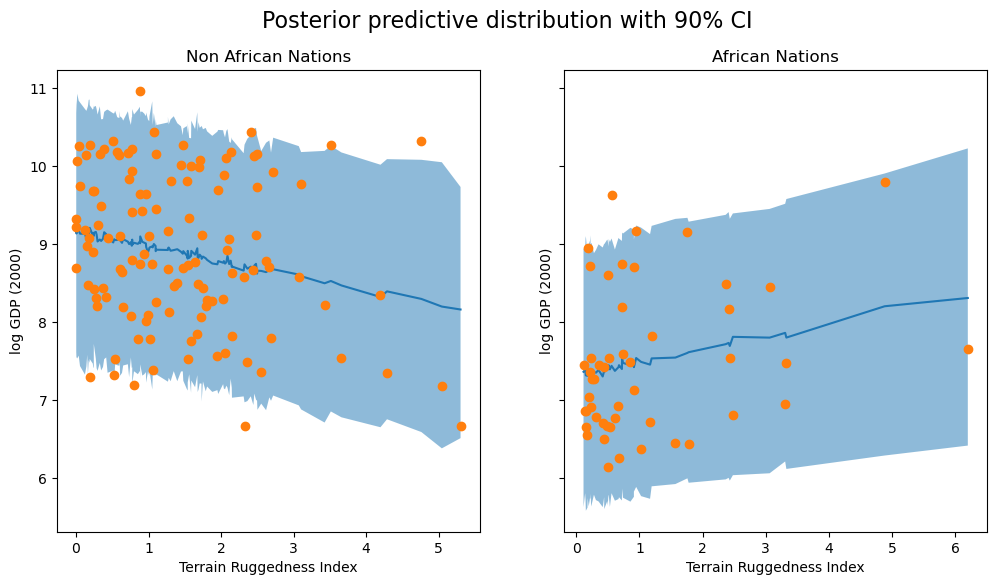

In [29]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations")

# Multi-variate

In [30]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

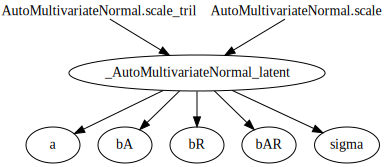

In [31]:
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

Elbo loss: 702.4906432628632
Elbo loss: 548.7576571702957
Elbo loss: 490.9642425775528
Elbo loss: 401.8139226436615
Elbo loss: 333.7779415845871
Elbo loss: 247.01825284957886
Elbo loss: 248.3894003033638
Elbo loss: 247.35121393203735
Elbo loss: 248.20958864688873
Elbo loss: 247.21006894111633


CPU times: user 2.02 s, sys: 125 ms, total: 2.15 s
Wall time: 2.11 s


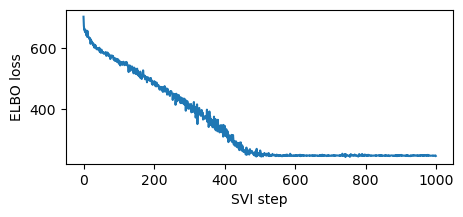

In [32]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

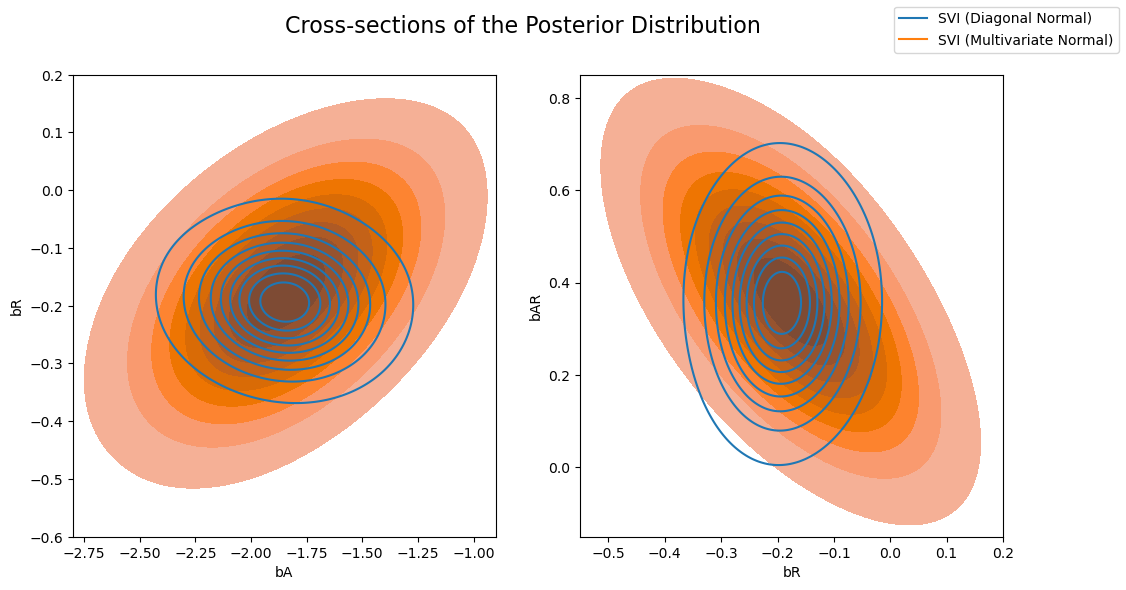

In [33]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

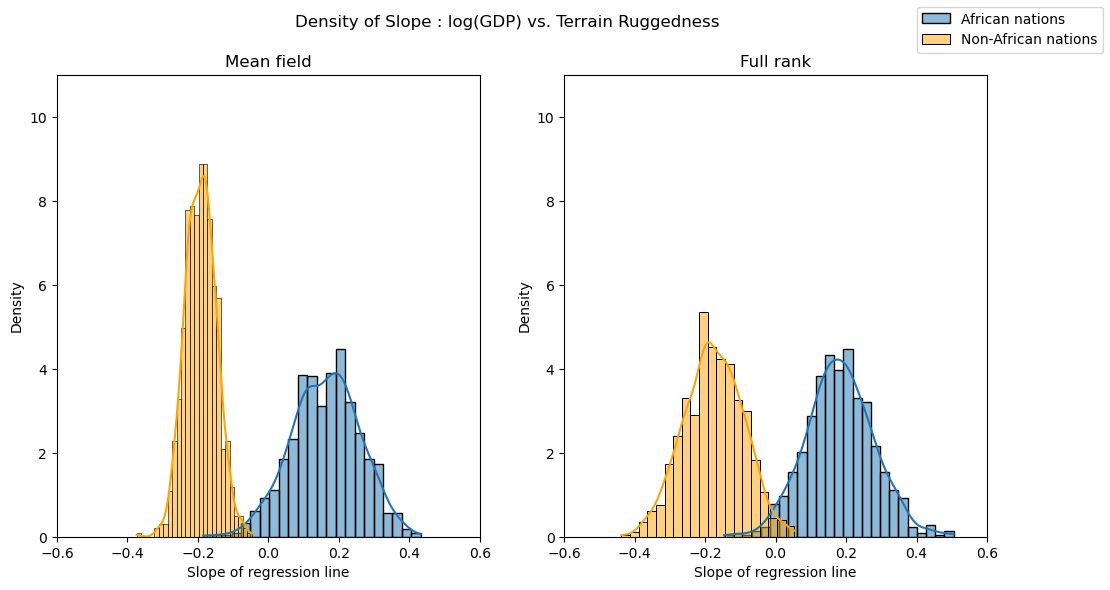

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

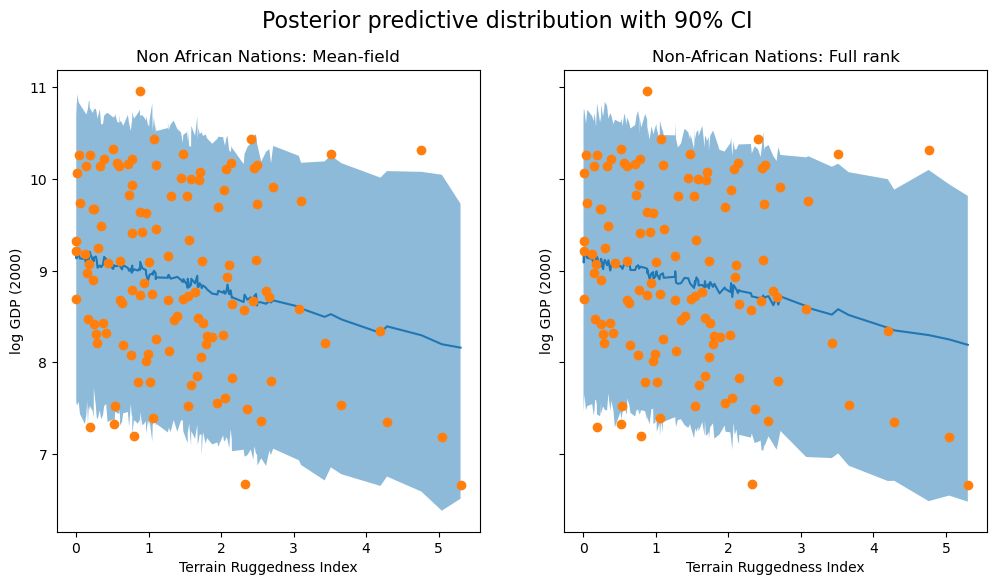

In [35]:
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");